In [1]:
using QuantEcon, CairoMakie, CUDA

In [2]:
CUDA.name(CUDA.device())

"NVIDIA GeForce RTX 3080 Ti Laptop GPU"

In [3]:
max_threads_per_block = CUDA.attribute(CUDA.device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

In [114]:
function params(;nk = 101)
    
    p = (α = 0.33, # Capital share
         β = 0.9, # Discount factor
         A = 1.0, # TFP
         δ = 0.1, # Depreciation rate
         kmin = 0.5, # Minimum capital
         kmax = 1.5, # Maximum capital
         θ = 1.0, # Grid expansion parameter
         γ = 2.0, # Risk aversion
         kgrid = zeros(Float32, nk), # Capital grid
         maxiter = 100000, # Maximum number of iterations
         tol = 1e-6) # Tolerance

    # Compute steady state capital
    Kss = ((p.A*p.α*p.β)/(1-p.β*(1.0-p.δ)))^(1/(1.0-p.α))

    # Create capital grid
    temp_grid = LinRange(0, 1, nk)
    kgrid = p.kmin*Kss .+ (p.kmax*Kss - p.kmin*Kss) * temp_grid.^p.θ
    
    #Return new NamedTuple
    p = (p..., kgrid = kgrid)
    
    return p
end

params (generic function with 1 method)

In [115]:
function gpu_unpack(p::NamedTuple)

    # Create CuArrays
    V_d = CuArray{Float32}(zeros(length(p.kgrid)))
    Vnew_d = CuArray{Float32}(zeros(length(p.kgrid),length(p.kgrid)))
    Vmax_d = CuArray{Float32}(zeros(length(p.kgrid)))
    pol_d = CuArray{Int32}(undef, length(p.kgrid))

    # Get params
    maxiter = p.maxiter
    tol = p.tol
    γ = p.γ
    β = p.β
    nk = length(p.kgrid)
    kgrid_d = CuArray(p.kgrid)
    # Initialise consumption
    cons_d = p.A .* kgrid_d.^p.α .+ (1 - p.δ) .* kgrid_d .- kgrid_d'
    
    # Run VFI
    gpu_vfi!(V_d, Vnew_d, Vmax_d, cons_d, pol_d, kgrid_d; maxiter = maxiter, tol = tol, γ = γ, β = β, nk = nk)

    return V_d, pol_d, kgrid_d
end

gpu_unpack (generic function with 1 method)

In [116]:
function gpu_vfi!(V, Vnew, Vmax, cons, pol, grid; maxiter, tol, γ, β, nk)
    error = tol + 1.0
    iter = 0
    pos_c = cons .> 0
    cons[.!pos_c] .= 1e-10
    c = (γ == 1.0 ? log.(cons) : (cons.^(1 - γ) .- 1) ./ (1 - γ))
    while ((error > tol) && (iter < maxiter))
        Vnew = c .+ β .* V'
        Vnew = reshape(Vnew', nk*nk, 1)
        block_size = max_threads_per_block
        num_blocks = ceil(Int, nk / block_size)
        @cuda threads=block_size blocks=num_blocks max_kernel!(Vnew, Vmax, pol, nk)
        error = maximum(abs.(Vmax .- V))
        V .= Vmax
        iter += 1
    end
    return V, pol
end

gpu_vfi! (generic function with 1 method)

In [117]:
function max_kernel!(Vnew, Vmax, pol, nk)
    idx = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if idx <= nk
        row_start = (idx - 1) * nk
        max_val = Vnew[row_start + 1]
        max_pos = 1
        for j in 2:nk
            if Vnew[row_start + j] > max_val
                max_val = Vnew[row_start + j]
                max_pos = j
            end
        end
        Vmax[idx] = max_val
        pol[idx] = max_pos
    end
    return
end

max_kernel! (generic function with 1 method)

In [119]:
psmall = params(nk = 128)
pbig = params(nk = 1024)

@time begin
    out_v_d_s, out_pol_d_s, out_grid_d_s = gpu_unpack(psmall)
end

@time begin
    out_v_d_b, out_pol_d_b, out_grid_d_b = gpu_unpack(pbig)
end

  0.013064 seconds (17.35 k allocations: 1.216 MiB)
  0.129508 seconds (30.82 k allocations: 13.542 MiB, 19.25% gc time)


(Float32[-0.8700738, -0.8662497, -0.86243385, -0.8586239, -0.8548221, -0.8510278, -0.84724045, -0.84346, -0.8396875, -0.8359212  …  1.268753, 1.2700292, 1.2713039, 1.272578, 1.2738514, 1.2751235, 1.2763952, 1.2776666, 1.2789365, 1.2802061], Int32[59, 60, 61, 61, 62, 63, 64, 65, 66, 67  …  948, 949, 950, 951, 952, 953, 953, 954, 955, 956], [0.9739271986116795, 0.9758312596060328, 0.977735320600386, 0.9796393815947393, 0.9815434425890924, 0.9834475035834457, 0.9853515645777989, 0.9872556255721522, 0.9891596865665054, 0.9910637475608587  …  2.904645046885859, 2.9065491078802124, 2.9084531688745656, 2.910357229868919, 2.912261290863272, 2.9141653518576254, 2.9160694128519786, 2.917973473846332, 2.919877534840685, 2.9217815958350384])

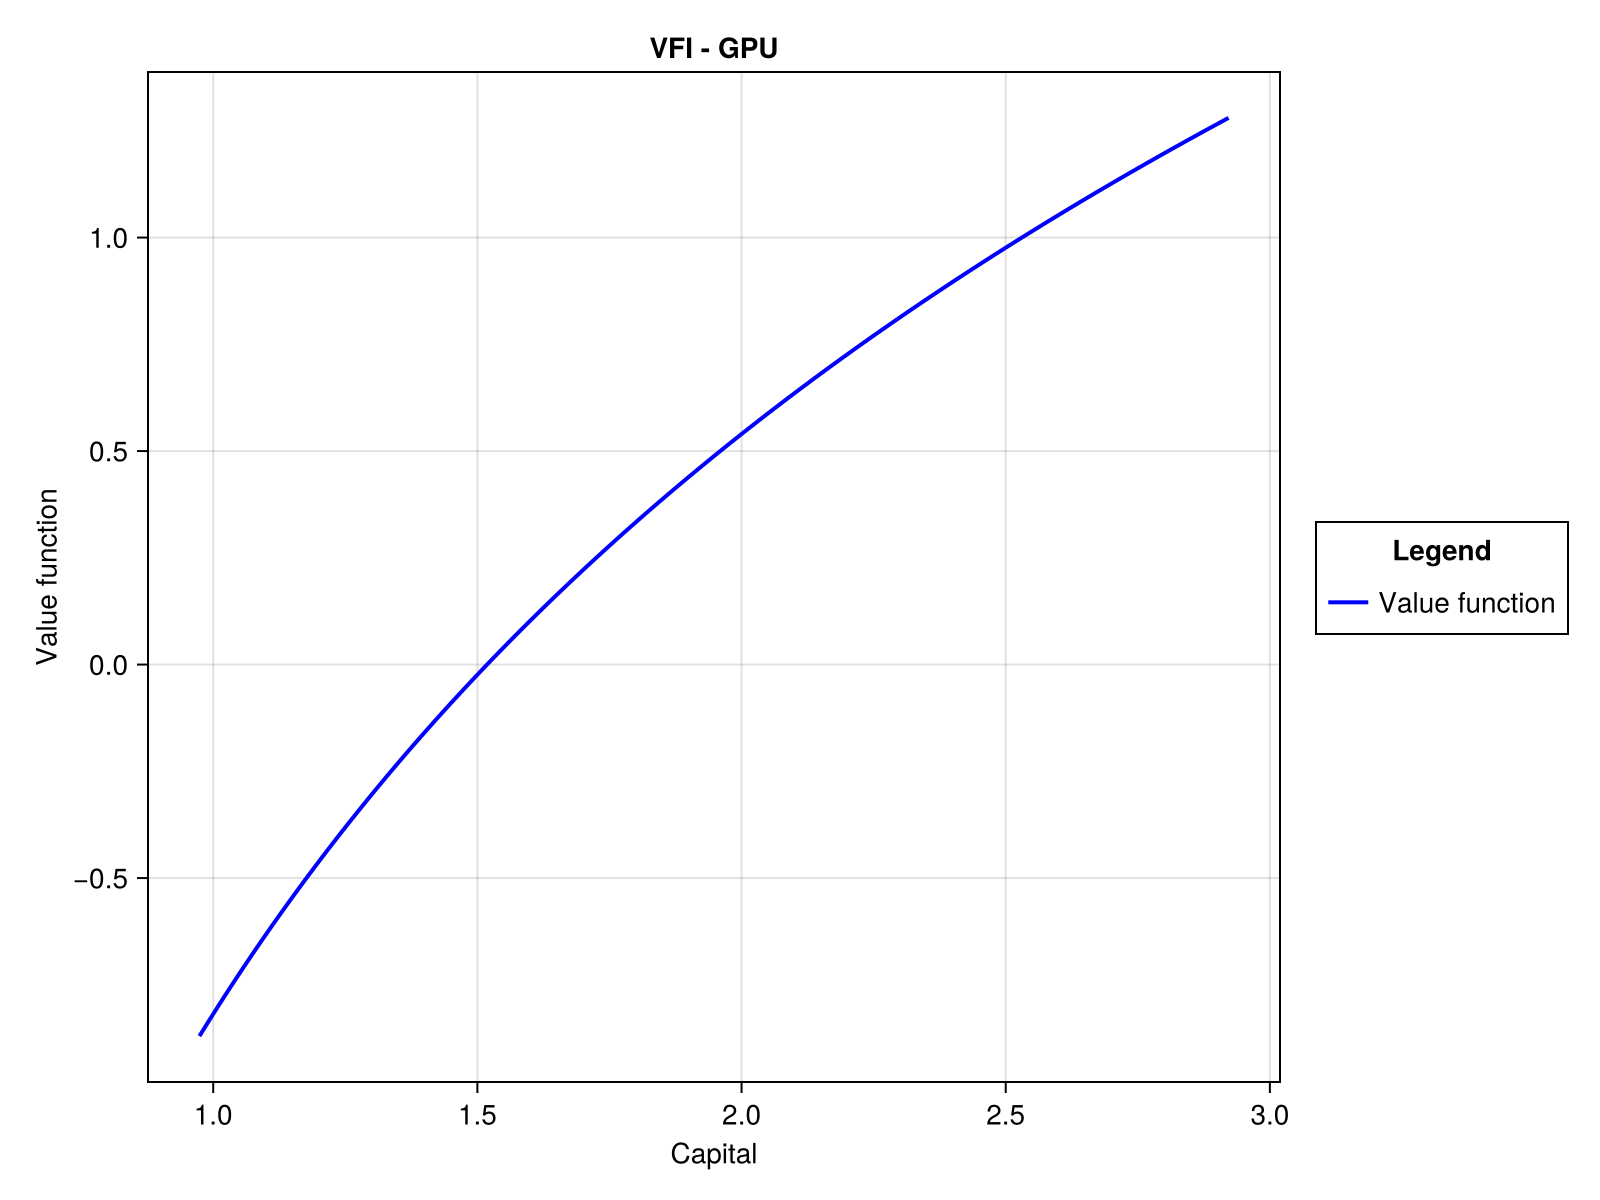

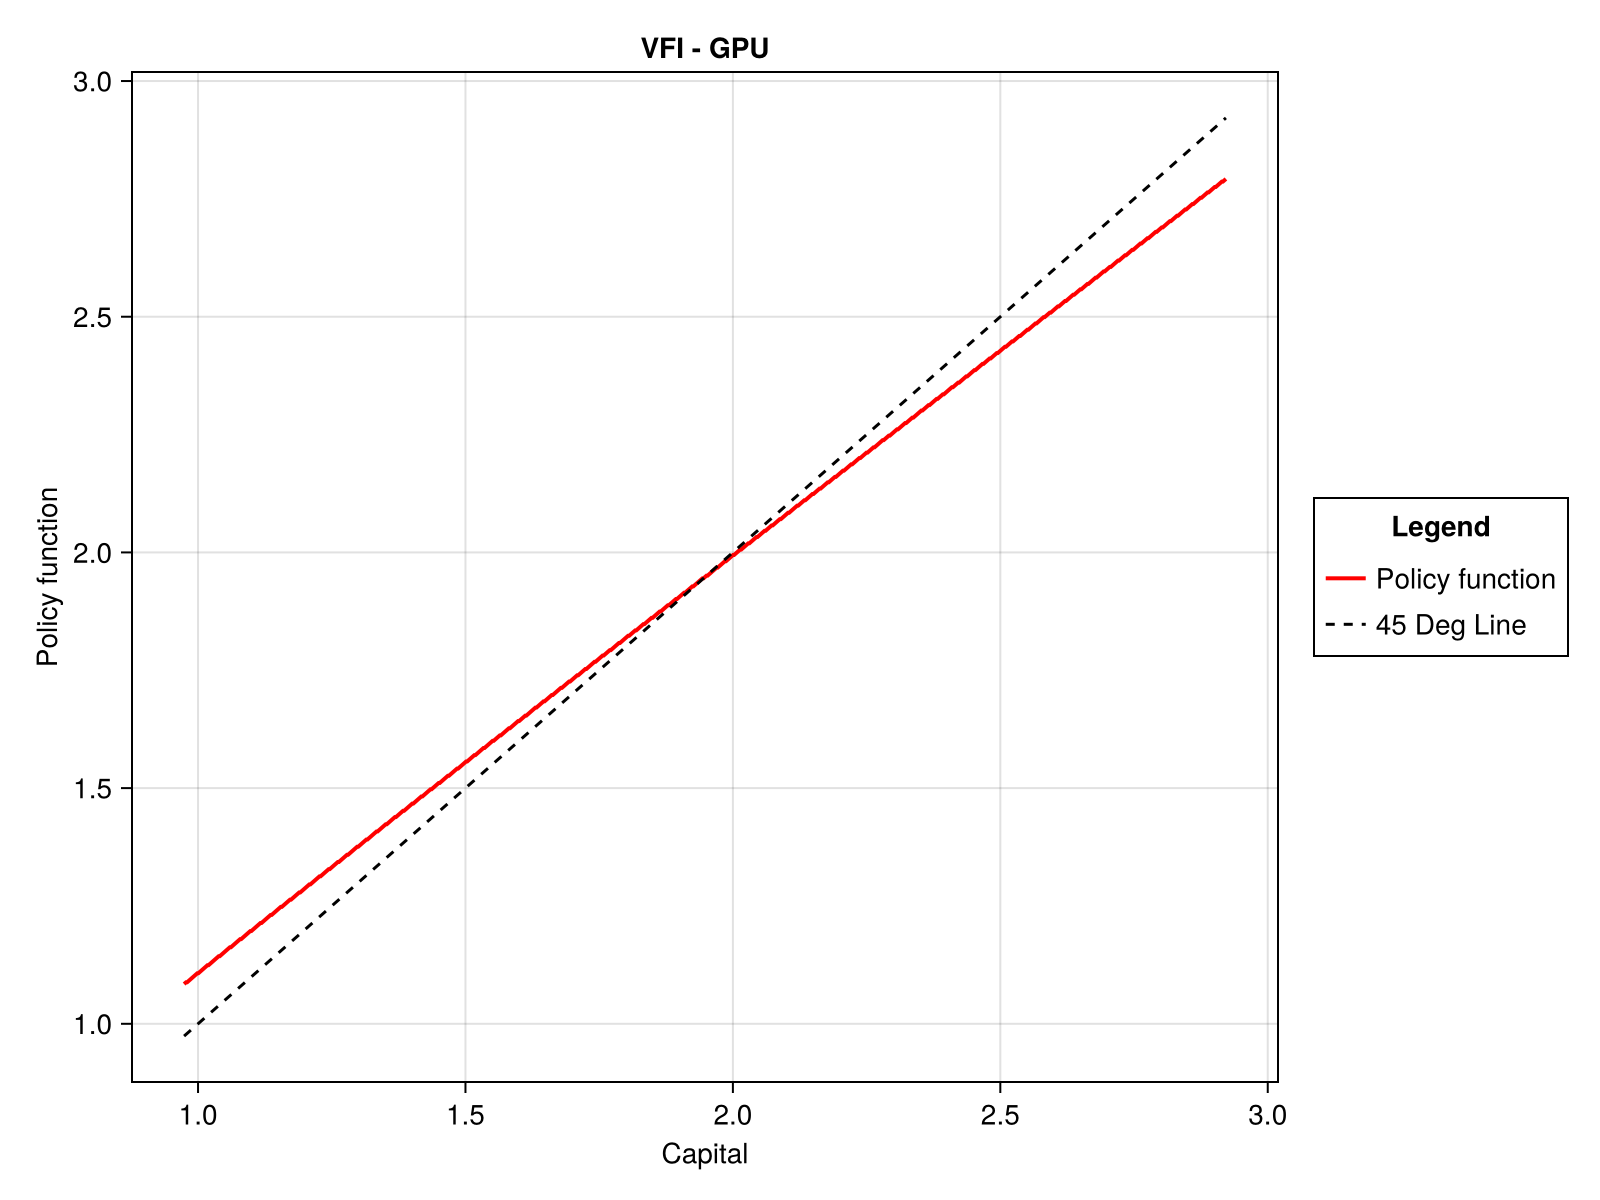

In [120]:
out_v_h = Array(out_v_d_b)
out_pol_h = Array(out_pol_d_b)
out_grid_h = Array(out_grid_d_b)

figv = Figure(size = (800,600))
axv = Axis(figv[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(axv, out_grid_h, out_v_h, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(figv[1,2], axv, "Legend", orientation = :vertical)
display(figv)

figp = Figure(size = (800,600))
axp = Axis(figp[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(axp, out_grid_h, out_grid_h[out_pol_h], color = :red, linewidth = 2, label = "Policy function")
lines!(axp, out_grid_h, out_grid_h, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(figp[1,2], axp, "Legend", orientation = :vertical)
figp